<a href="https://colab.research.google.com/github/ivn-srg/data-analysis-course-omsu/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5%209/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_9_%D0%90%D0%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="background-color: #001f3f; color: #ff0; padding: 12px; border: 2px solid #fff; text-align: center;border-radius: 8px;">Ad Click Prediction</h1>


In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from scipy.stats import norm, skew, probplot
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings(action='ignore')

# EDA - Exploratory Data Analysis

In [73]:
data = pd.read_csv("/content/ad_click_dataset.csv")
data

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...,...,...
9995,8510,User8510,NaN,NaN,Mobile,Top,Education,NaN,0
9996,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,3914,User3914,NaN,Male,Mobile,Side,NaN,Morning,0
9998,7924,User7924,NaN,NaN,Desktop,NaN,Shopping,Morning,1


In [74]:
data = data.drop(columns=['id','full_name'], axis=1)

In [75]:
data.shape

(10000, 7)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               5234 non-null   float64
 1   gender            5307 non-null   object 
 2   device_type       8000 non-null   object 
 3   ad_position       8000 non-null   object 
 4   browsing_history  5218 non-null   object 
 5   time_of_day       8000 non-null   object 
 6   click             10000 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 547.0+ KB


In [77]:
data

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,NaN,Male,Desktop,Top,NaN,NaN,1
2,41.0,Non-Binary,NaN,Side,Education,Night,1
3,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...
9995,NaN,NaN,Mobile,Top,Education,NaN,0
9996,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,NaN,Male,Mobile,Side,NaN,Morning,0
9998,NaN,NaN,Desktop,NaN,Shopping,Morning,1


In [78]:
num_cols = data.select_dtypes(include=['float64', 'int64'])
cat_cols = data.select_dtypes(include=['object'])

print('Numeric Variables:')
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['age', 'click']

Categorical Variables:
['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']


In [79]:
for col in cat_cols:
  print('We Have {} Unique values. Values in the {} Column: {}'.format(len(data[col].unique()),col,data[col].unique()))
  print('__'*30)

We Have 4 Unique values. Values in the gender Column: [nan 'Male' 'Non-Binary' 'Female']
____________________________________________________________
We Have 4 Unique values. Values in the device_type Column: ['Desktop' nan 'Mobile' 'Tablet']
____________________________________________________________
We Have 4 Unique values. Values in the ad_position Column: ['Top' 'Side' nan 'Bottom']
____________________________________________________________
We Have 6 Unique values. Values in the browsing_history Column: ['Shopping' nan 'Education' 'Entertainment' 'Social Media' 'News']
____________________________________________________________
We Have 5 Unique values. Values in the time_of_day Column: ['Afternoon' nan 'Night' 'Evening' 'Morning']
____________________________________________________________


In [80]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5234.0,40.197363,13.126420,18.0,29.0,39.5,52.0,64.0
click,10000.0,0.650000,0.476993,0.0,0.0,1.0,1.0,1.0


In [81]:
for feature in num_cols:
  zero_values = (data[feature] == 0).sum()
  null_values = data[feature].isnull().sum()
  unique_values = len(data[feature].unique())

  print(f"Feature: {feature}")
  print(f"Number of 0 Values: {zero_values}")
  print(f"Number of Null Values: {null_values}")
  print(f"Unique Values: {unique_values}")
  print("="*30)

Feature: age
Number of 0 Values: 0
Number of Null Values: 4766
Unique Values: 48
Feature: click
Number of 0 Values: 3500
Number of Null Values: 0
Unique Values: 2


# Missing Values

In [82]:
data.isnull().sum()

,0
age,4766
gender,4693
device_type,2000
ad_position,2000
browsing_history,4782
time_of_day,2000
click,0


<Axes: title={'center': 'Heatmap for the null values in each column'}>

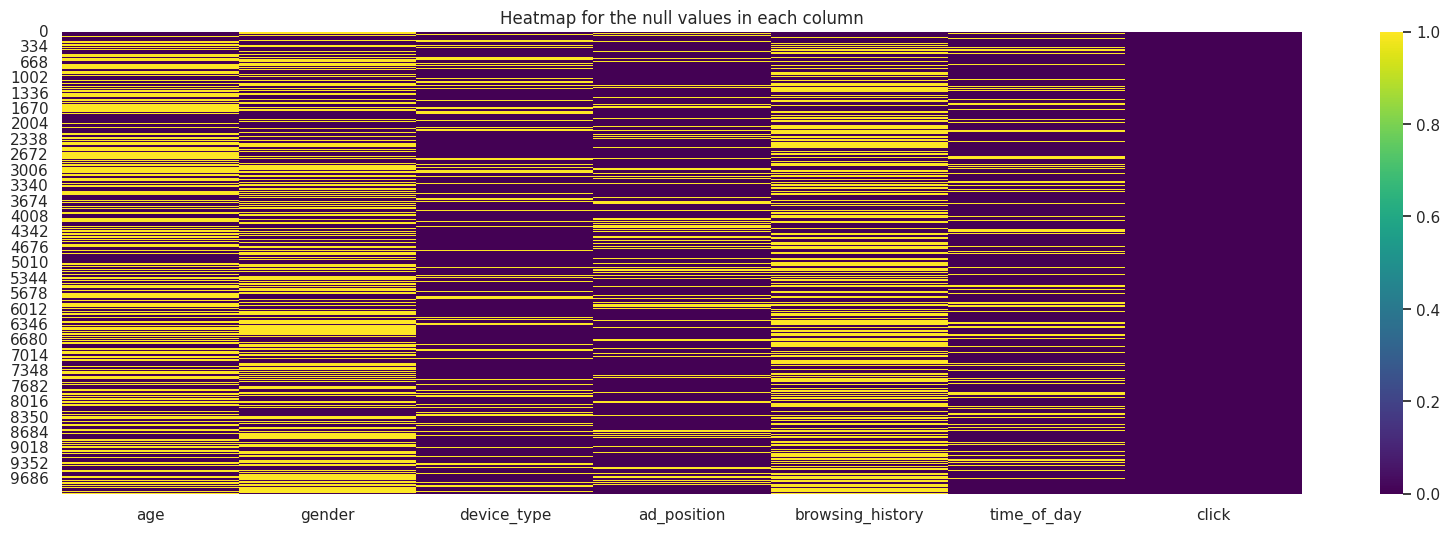

In [83]:
plt.figure(figsize=(20,6))
plt.title('Heatmap for the null values in each column')
sns.heatmap(data.isnull(),cmap='viridis')

**Применение метода KNN для заполнения пропущенных значений. Сначала проанализируем строки с пропущенными значениями, чтобы определить подходящих соседей.**

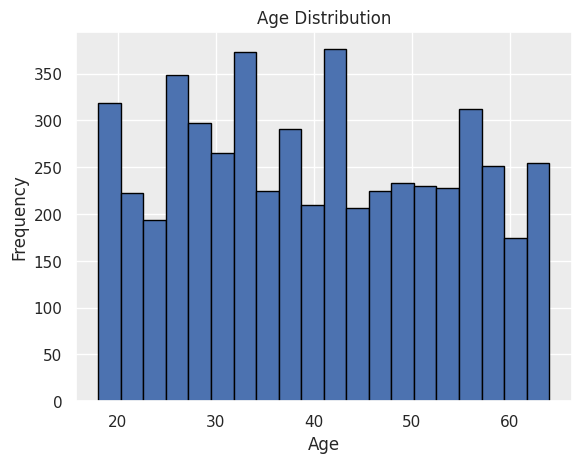

In [84]:
plt.hist(data['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**💡 Что делает KNNImputer:**

KNNImputer — это метод заполнения пропущенных значений, который ищет похожие строки (по другим признакам) и использует их значения, чтобы заполнить пустоты.

**🔍 Как это работает пошагово:**

- Для каждой строки с пропуском алгоритм находит k ближайших соседей (другие строки без пропуска в этом месте), которые максимально похожи по остальным признакам.

- Смотрит, что у этих соседей в нужной ячейке:

 - Если это число — берет среднее.

 - Если это категория — сначала кодирует её как число, потом берет среднее, округляет до ближайшего целого и декодирует обратно.

- Вставляет найденное значение на место пропуска.

In [85]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

def knn_impute_all(data, n_neighbors=5):
    # Создаем копию исходного датафрейма
    df = data.copy()

    # Определяем категориальные и числовые столбцы
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    num_cols = df.select_dtypes(include=[np.number]).columns

    # Словарь для обратного преобразования категорий
    category_mappings = {}

    # Закодируем категориальные переменные
    for col in cat_cols:
        df[col] = df[col].astype('category')
        category_mappings[col] = dict(enumerate(df[col].cat.categories))
        df[col] = df[col].cat.codes.replace(-1, np.nan)  # пропуски как np.nan

    # Применяем KNNImputer ко всему датафрейму
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed_array = imputer.fit_transform(df)

    # Возвращаем результат в DataFrame
    df_imputed = pd.DataFrame(df_imputed_array, columns=df.columns)

    # Обратное преобразование категориальных переменных
    for col in cat_cols:
        df_imputed[col] = df_imputed[col].round().astype(int).map(category_mappings[col])

    return df_imputed


# 🔧 Пример использования:
df_imputed = knn_impute_all(data)
data = df_imputed

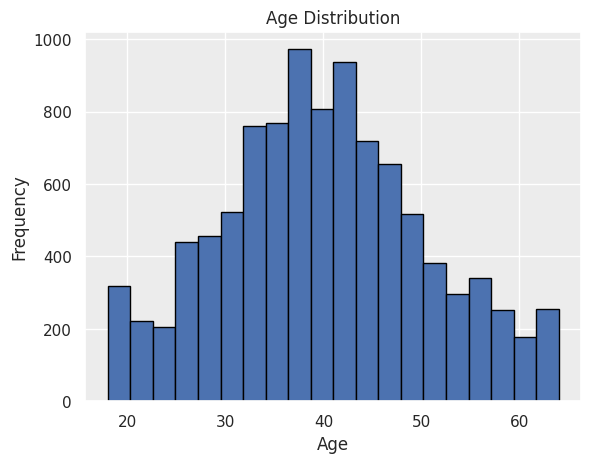

In [86]:
plt.hist(data['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [87]:
data.isnull().sum()

,0
age,0
gender,0
device_type,0
ad_position,0
browsing_history,0
time_of_day,0
click,0


Тест Стьюдента (проверка различий по возрасту между кликнувшими и не кликнувшими)

| Тема              | Что проверяет                          | Когда используется                        |
|-------------------|----------------------------------------|-------------------------------------------|
| Тест Стьюдента     | Средние значимо различаются?           | Сравнить 2 группы                         |
| Тест Рамсея        | Спецификация регрессии верна?          | Проверить полноту модели                  |



In [88]:
from scipy.stats import ttest_ind

# Разделяем данные на 2 группы: кликнули и не кликнули
clicked = data[data['click'] == 1]['age']
not_clicked = data[data['click'] == 0]['age']

# Применяем независимый тест Стьюдента
t_stat, p_value = ttest_ind(clicked, not_clicked)

print(f"Статистика t-теста: {t_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация:
if p_value < 0.05:
    print('Вывод: есть статистически значимое различие в возрасте между кликнувшими и не кликнувшими.')
else:
    print('Вывод: нет статистически значимого различия в возрасте между кликнувшими и не кликнувшими.')


Статистика t-теста: -13.2334
P-значение: 0.0000
Вывод: есть статистически значимое различие в возрасте между кликнувшими и не кликнувшими.


# Correlation

In [89]:
corr = num_cols.corr()
corr

,age,click
age,1.000000,-0.082056
click,-0.082056,1.000000


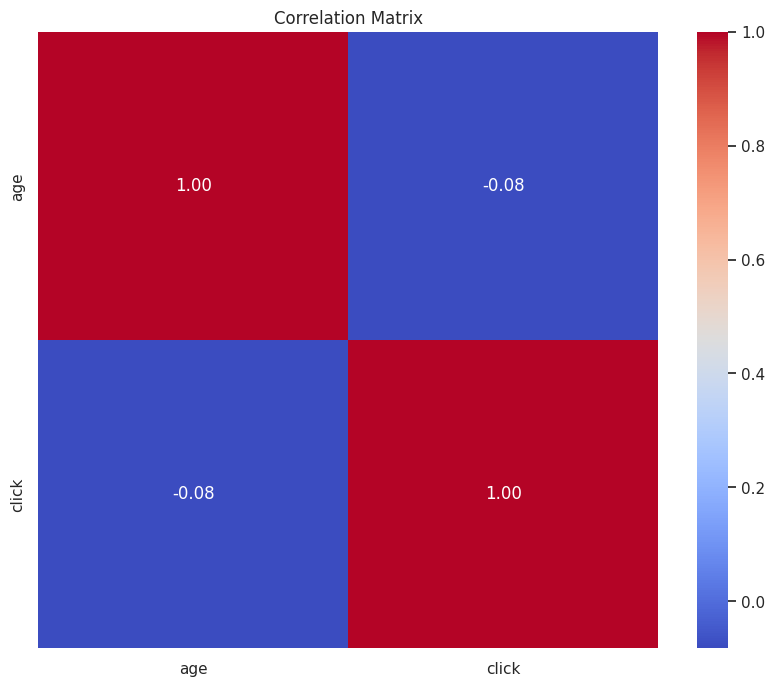

In [90]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

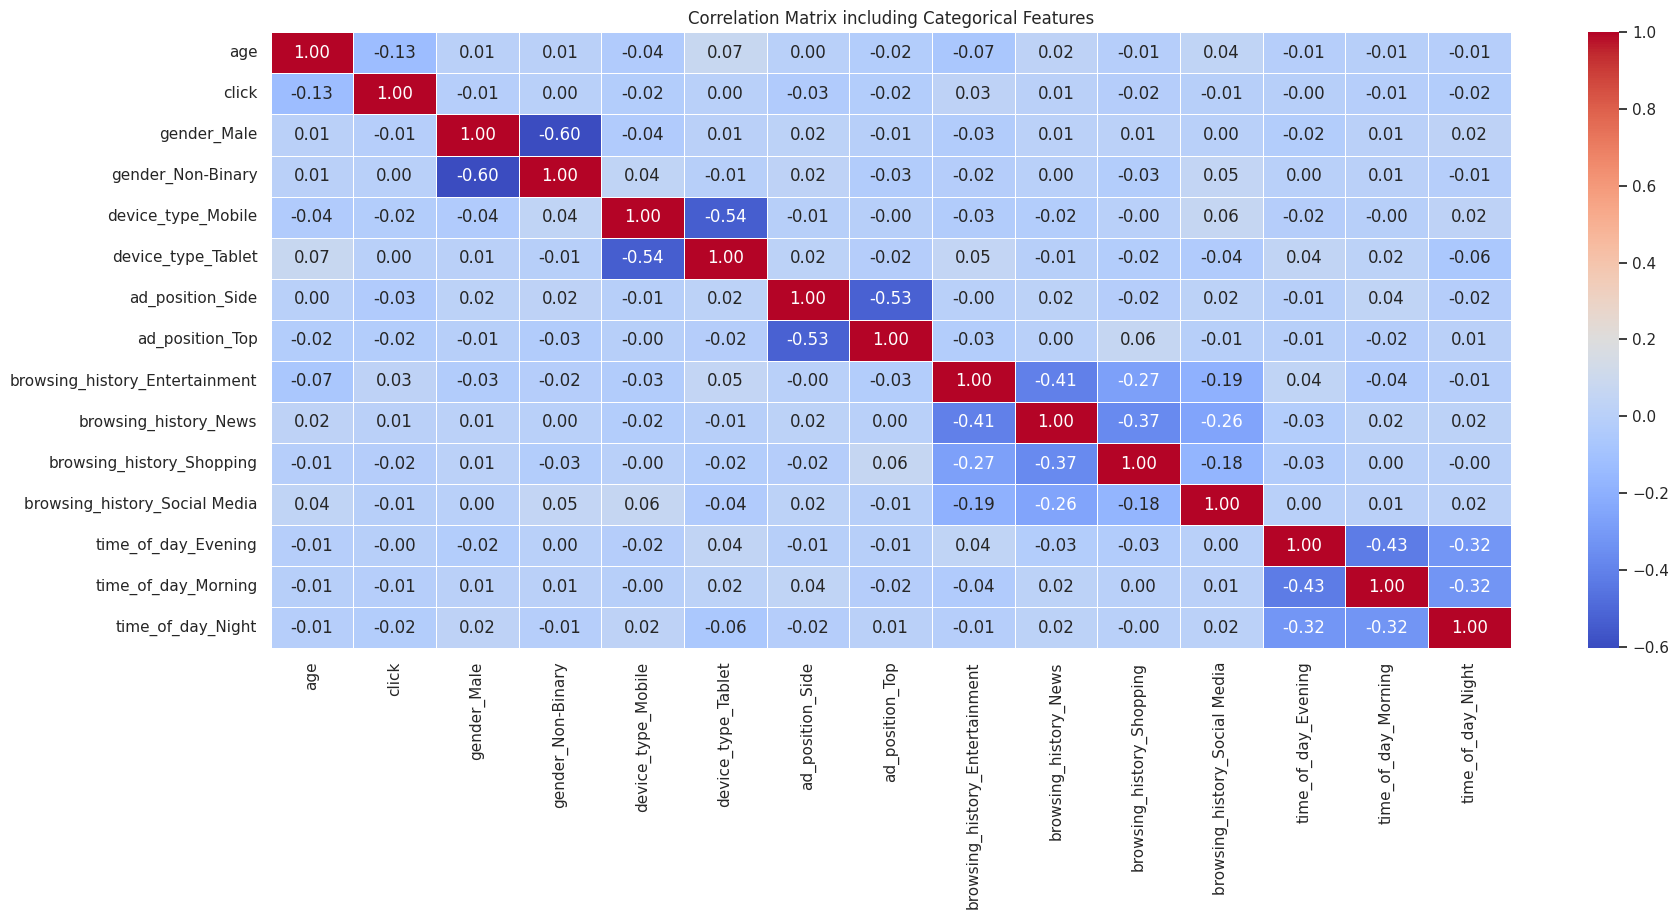

In [91]:
data_encoded = pd.get_dummies(data, drop_first=True)
corr_matrix = data_encoded.corr()

# Heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()


In [92]:
corr_matrix['click']

,click
age,-0.131203
click,1.000000
gender_Male,-0.012012
gender_Non-Binary,0.000101
device_type_Mobile,-0.023212
device_type_Tablet,0.001430
ad_position_Side,-0.034565
ad_position_Top,-0.024412
browsing_history_Entertainment,0.026494
browsing_history_News,0.007483


# Outlier

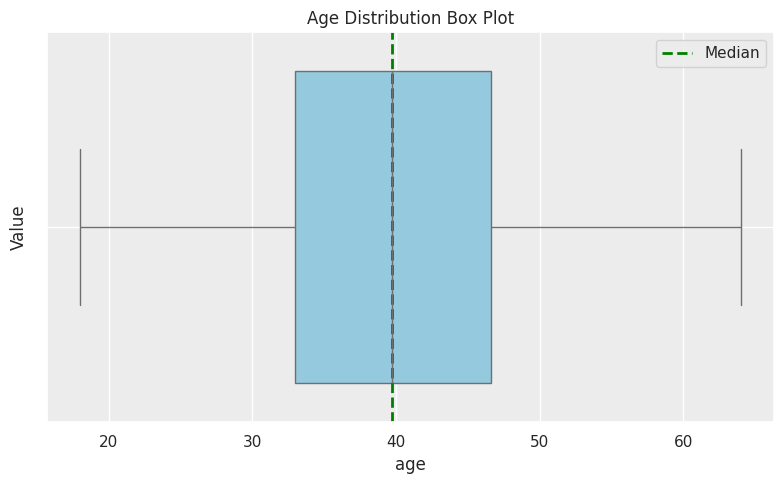

In [93]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="age", color='skyblue', flierprops=dict(marker='o', markersize=8, markerfacecolor='red'))
plt.title('Age Distribution Box Plot')
plt.xlabel('age')
plt.ylabel('Value')
median_age = data['age'].median()
plt.axvline(median_age, color='green', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
min_age = data['age'].min()
max_age = data['age'].max()

print(f"Minimum age value: {min_age}")
print(f"Maximum age value: {max_age}")

Minimum age value: 18.0
Maximum age value: 64.0


**No Outliers**

# Visualizations

## Click

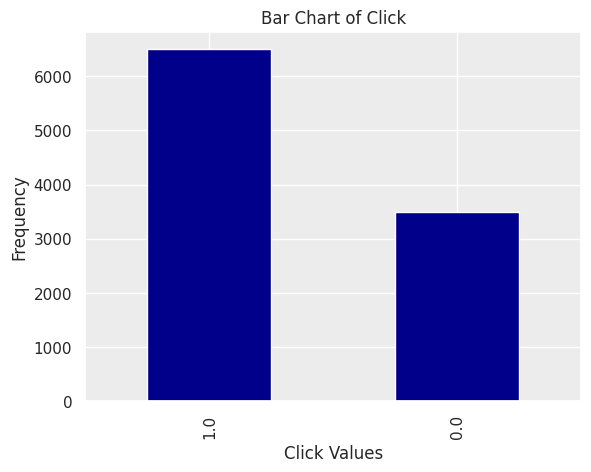

In [95]:
data['click'].value_counts().plot(kind='bar', color='darkblue')
plt.xlabel('Click Values')
plt.ylabel('Frequency')
plt.title('Bar Chart of Click')
plt.show()


In [96]:
distribution_click = data['click'].value_counts(normalize=True) * 100

print(distribution_click)

click
1.0    65.0
0.0    35.0
Name: proportion, dtype: float64


> **Distribution is Imbalanced. Smote or other methods can be considered to balance this.**

## Age

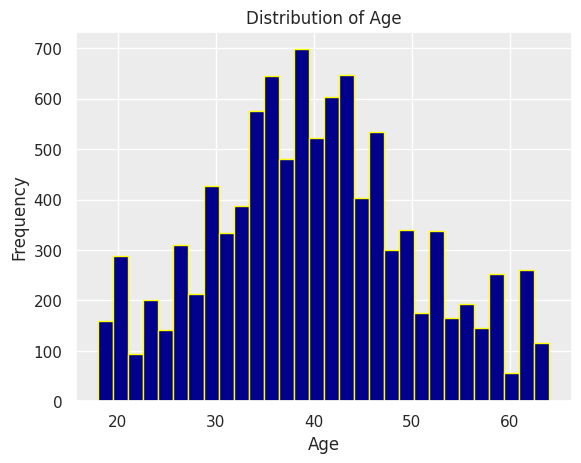

In [97]:
plt.hist(data['age'], bins=30, color='darkblue', edgecolor='yellow')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Gender

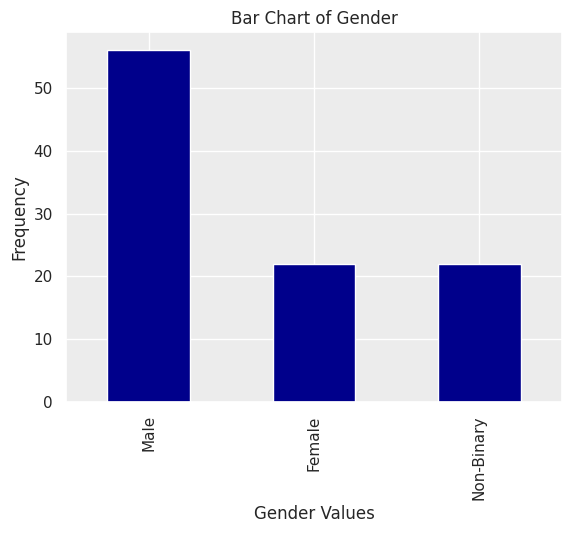

In [98]:
click_counts = data[data['click'] == 1]['gender'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Gender Values')
plt.ylabel('Frequency')
plt.title('Bar Chart of Gender')
plt.show()

> **Большинство в выборке составляют мужчины, примерно одинаковые доли имеют женщины и небинарные персоны**

## Device Type

In [99]:
data['device_type'].value_counts()

,count
device_type,
Mobile,4292
Desktop,2945
Tablet,2763


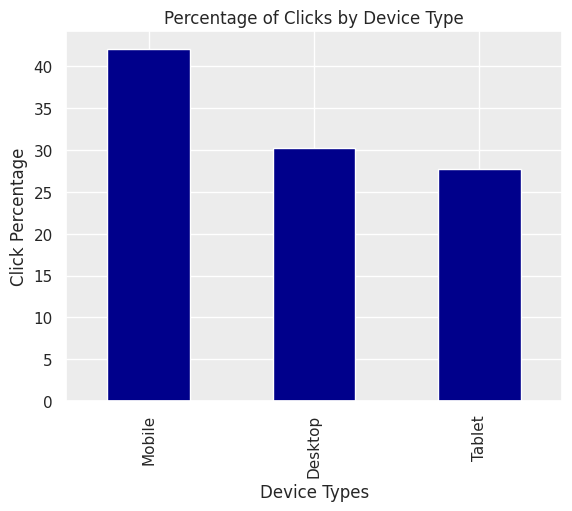

In [100]:
click_counts = data[data['click'] == 1]['device_type'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Device Types')
plt.ylabel('Click Percentage')
plt.title('Percentage of Clicks by Device Type')
plt.show()

> **Большинство составляют пользователи мобильных устройств, остальное делят пользователи компьютеров и планшетов**

## Ad Position

In [101]:
data['ad_position'].value_counts()

,count
ad_position,
Side,4250
Bottom,3007
Top,2743


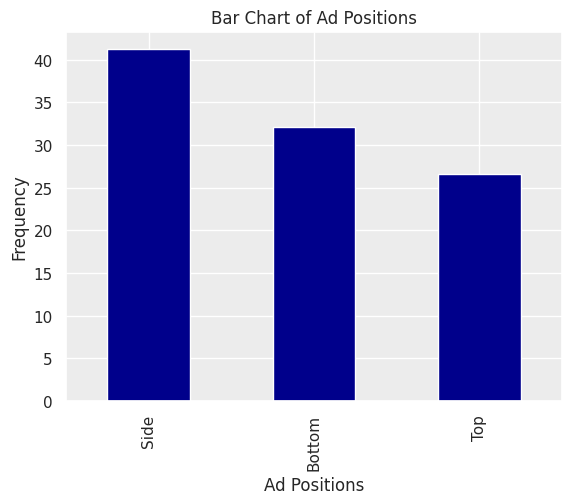

In [102]:
click_counts = data[data['click'] == 1]['ad_position'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Ad Positions')
plt.ylabel('Frequency')
plt.title('Bar Chart of Ad Positions')
plt.show()

## Browsing History

In [103]:
data['browsing_history'].value_counts()

,count
browsing_history,
News,3523
Entertainment,2321
Shopping,1992
Social Media,1099
Education,1065


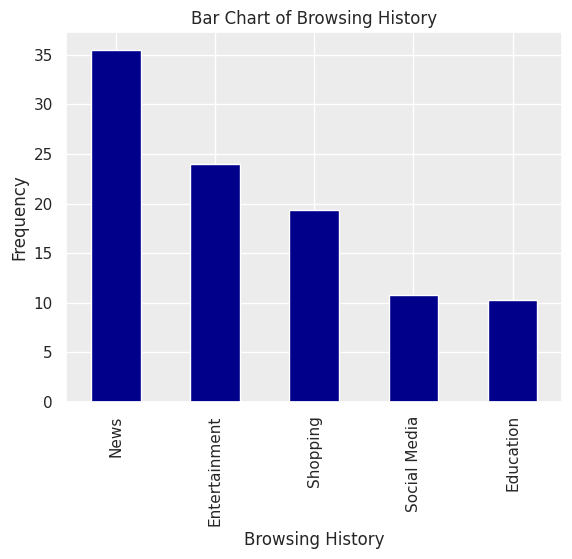

In [104]:
click_counts = data[data['click'] == 1]['browsing_history'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Browsing History')
plt.ylabel('Frequency')
plt.title('Bar Chart of Browsing History')
plt.show()

## Time of Day

In [105]:
data['time_of_day'].value_counts()

,count
time_of_day,
Morning,3024
Evening,2969
Afternoon,2070
Night,1937


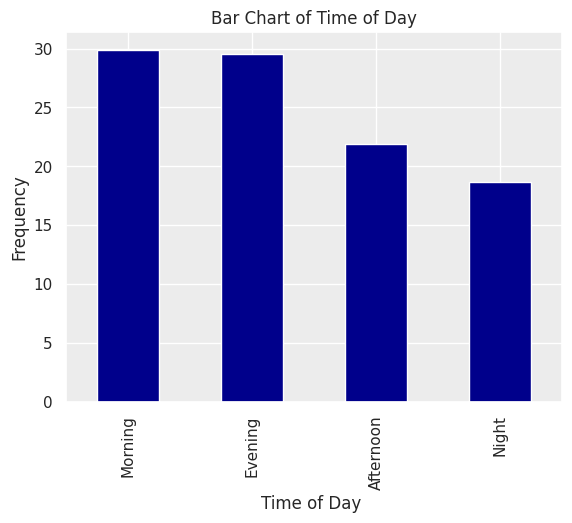

In [106]:
click_counts = data[data['click'] == 1]['time_of_day'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Time of Day ')
plt.ylabel('Frequency')
plt.title('Bar Chart of Time of Day')

plt.show()

## Device Type - Ad Position

## Device Type - Age

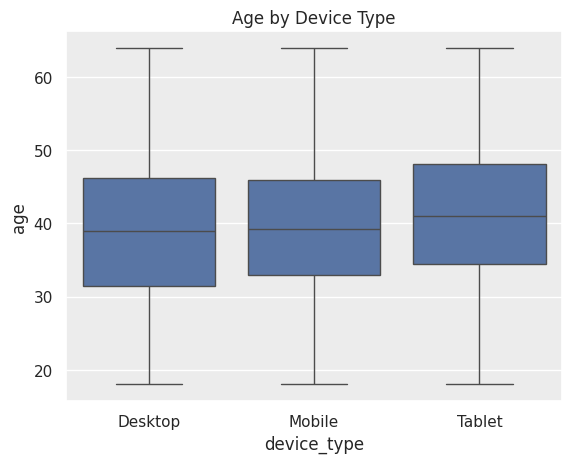

In [107]:
sns.boxplot(x='device_type', y='age', data=data)
plt.title('Age by Device Type')
plt.show()

## Time of Day - Age

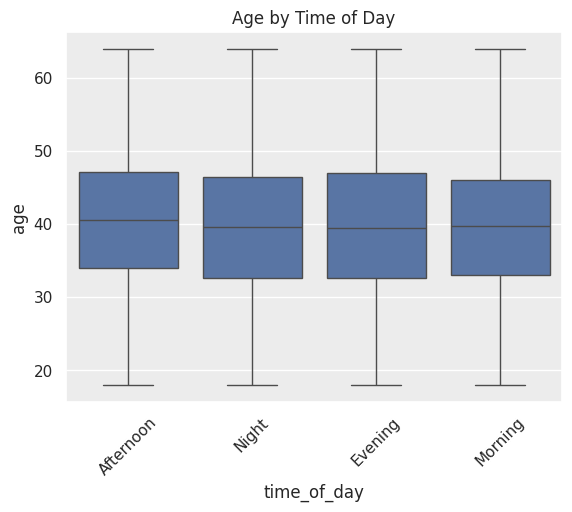

In [108]:
sns.boxplot(x='time_of_day', y='age', data=data)
plt.title('Age by Time of Day')
plt.xticks(rotation=45)
plt.show()

# Encode

In [109]:
for col in cat_cols:
  print('We Have {} Unique values. Values in the {} Column: {}'.format(len(data[col].unique()),col,data[col].unique()))
  print('__'*30)

We Have 3 Unique values. Values in the gender Column: ['Male' 'Non-Binary' 'Female']
____________________________________________________________
We Have 3 Unique values. Values in the device_type Column: ['Desktop' 'Mobile' 'Tablet']
____________________________________________________________
We Have 3 Unique values. Values in the ad_position Column: ['Top' 'Side' 'Bottom']
____________________________________________________________
We Have 5 Unique values. Values in the browsing_history Column: ['Shopping' 'News' 'Education' 'Entertainment' 'Social Media']
____________________________________________________________
We Have 4 Unique values. Values in the time_of_day Column: ['Afternoon' 'Night' 'Evening' 'Morning']
____________________________________________________________


In [110]:
data = pd.get_dummies(data, columns=cat_cols.columns, drop_first=True).astype(int)

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   age                             10000 non-null  int64
 1   click                           10000 non-null  int64
 2   gender_Male                     10000 non-null  int64
 3   gender_Non-Binary               10000 non-null  int64
 4   device_type_Mobile              10000 non-null  int64
 5   device_type_Tablet              10000 non-null  int64
 6   ad_position_Side                10000 non-null  int64
 7   ad_position_Top                 10000 non-null  int64
 8   browsing_history_Entertainment  10000 non-null  int64
 9   browsing_history_News           10000 non-null  int64
 10  browsing_history_Shopping       10000 non-null  int64
 11  browsing_history_Social Media   10000 non-null  int64
 12  time_of_day_Evening             10000 non-null  int64
 13  ti

# Models

In [112]:
KNN = data.copy()
Logistic = data.copy()

## KNN

In [113]:
X = KNN.drop('click', axis=1)
y = KNN['click']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

In [116]:
# create numpy array for future K value
neighbors = np.arange(1, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

In [117]:
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

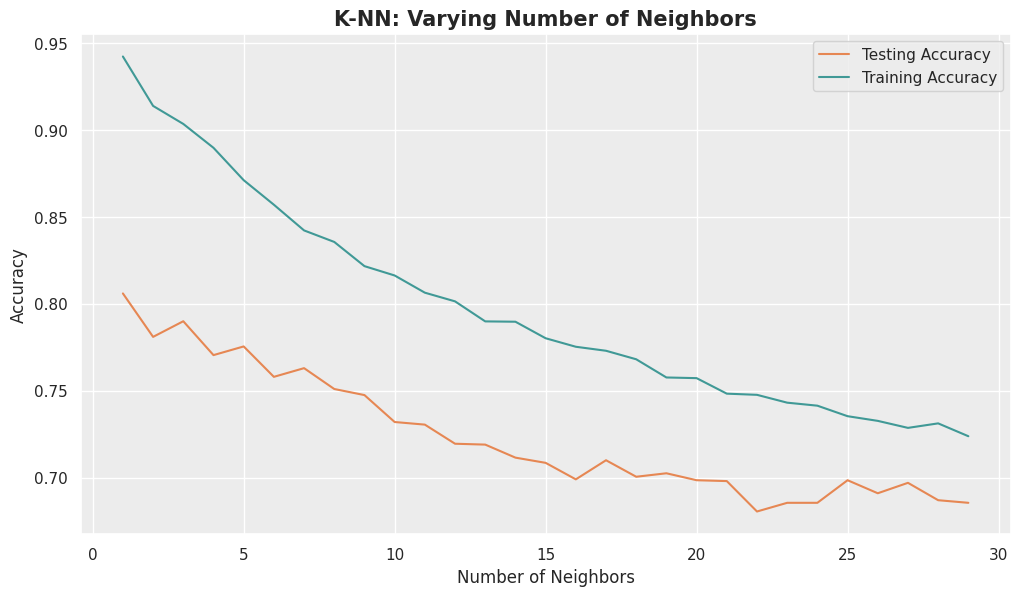

In [118]:
# Generate plot
sns.set(rc={'axes.facecolor':'#ECECEC'}) #background color of all plots
plt.figure(figsize=(12,6.5))
plt.title(label='K-NN: Varying Number of Neighbors', fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy', color='#E68753')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy', color = '#409996')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [119]:
classifier_knn = KNeighborsClassifier(n_neighbors = 3, weights='distance', algorithm = 'auto')

classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [120]:
y_pred = classifier_knn.predict(X_test)

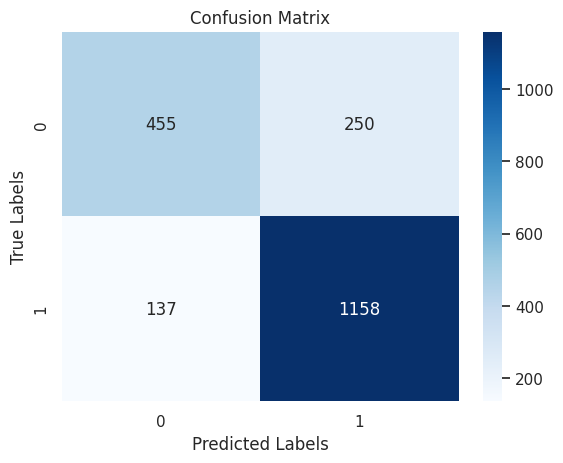

In [121]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [122]:
accuracy_knn = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_knn)

precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)

print("Precision:", precision_knn)
print("Recall:", recall_knn)

f1_knn = f1_score(y_test, y_pred)
print("F1 Score:", f1_knn)

Accuracy: 0.8065
Precision: 0.8224431818181818
Recall: 0.8942084942084942
F1 Score: 0.8568257491675916


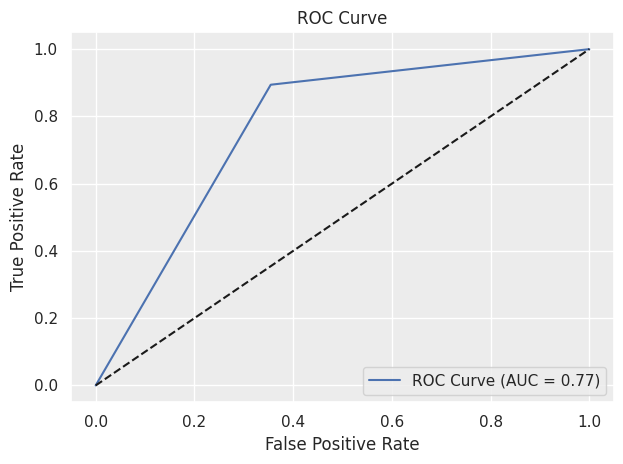

In [123]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Logistic

In [124]:
X = Logistic.drop("click", axis=1)
y = Logistic["click"]

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [126]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

In [127]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

LogisticRegression()

In [128]:
y_pred = logistic_reg.predict(X_test)

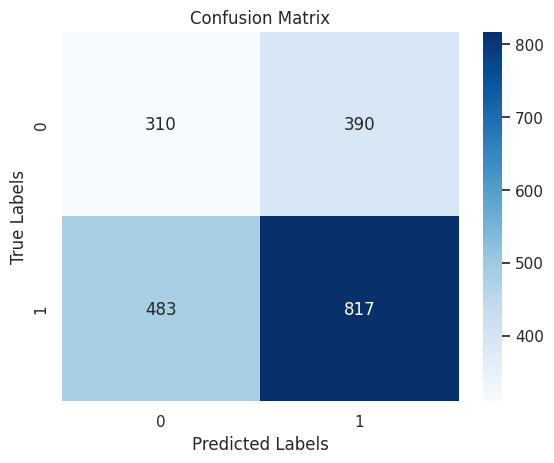

In [129]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [130]:
accuracy_log = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_log)

precision_log = precision_score(y_test, y_pred)
recall_log = recall_score(y_test, y_pred)

print("Precision:", precision_log)
print("Recall:", recall_log)

f1_log = f1_score(y_test, y_pred)
print("F1 Score:", f1_log)

Accuracy: 0.5635
Precision: 0.6768848384424192
Recall: 0.6284615384615385
F1 Score: 0.6517750299162346


In [131]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report

# Создаем объект для генерации полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)

# Генерируем полиномиальные признаки для обучающей выборки
X_train_poly = poly.fit_transform(X_train)

# Преобразуем тестовую выборку
X_test_poly = poly.transform(X_test)

# Создаем модель логистической регрессии
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')

# Обучаем модель на полиномиальных признаках
log_reg.fit(X_train_poly, y_train)

# Предсказываем ответы для тестовой выборки
y_pred = log_reg.predict(X_test_poly)

# Оцениваем качество модели
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.50      0.45       700
           1       0.70      0.61      0.65      1300

    accuracy                           0.57      2000
   macro avg       0.55      0.56      0.55      2000
weighted avg       0.60      0.57      0.58      2000



In [132]:
accuracy_log = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_log)

precision_log = precision_score(y_test, y_pred)
recall_log = recall_score(y_test, y_pred)

print("Precision:", precision_log)
print("Recall:", recall_log)

f1_log = f1_score(y_test, y_pred)
print("F1 Score:", f1_log)

Accuracy: 0.5735
Precision: 0.6951965065502184
Recall: 0.6123076923076923
F1 Score: 0.6511247443762781


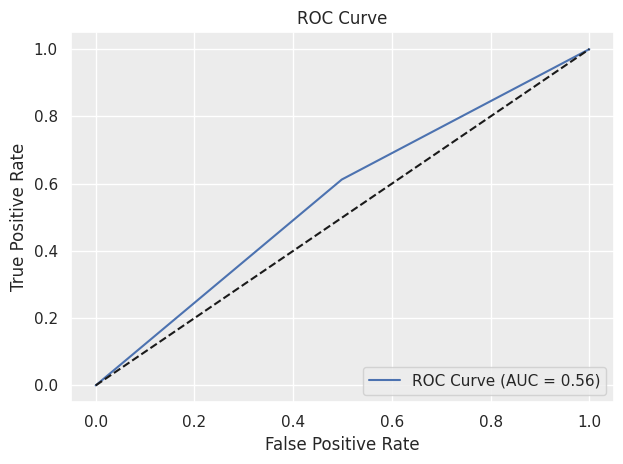

In [133]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Тест Рамсея (RESET-тест) (проверка правильности спецификации регрессии)

In [134]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset

# Строим логистическую регрессию
model = sm.Logit(y, X).fit()

# Применяем тест Рамсея (проверка наличия пропущенных нелинейных связей)
reset_test = linear_reset(model, power=2, use_f=True)

print('Статистика F-теста:', reset_test.fvalue)
print('P-значение:', reset_test.pvalue)

# Интерпретация:
if reset_test.pvalue < 0.05:
    print('Вывод: модель имеет пропущенные нелинейности, стоит пересмотреть спецификацию.')
else:
    print('Вывод: спецификация модели корректна.')


Optimization terminated successfully.
         Current function value: 0.648524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648471
         Iterations 5
Статистика F-теста: 1.0729357180094727
P-значение: 0.30030836162183383
Вывод: спецификация модели корректна.


In [135]:
coefficients = log_reg.coef_[0]  # В log_reg уже обученная модель

# Получаем имена признаков
feature_names = poly.get_feature_names_out(X.columns)

# Создаем DataFrame для наглядности
feature_importance = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients
})

# Сортируем по абсолютной величине коэффициента
feature_importance['|Коэффициент|'] = feature_importance['Коэффициент'].abs()
feature_importance = feature_importance.sort_values(by='|Коэффициент|', ascending=False)

# Выводим важность признаков
print(feature_importance[['Признак', 'Коэффициент']])

                                               Признак  Коэффициент
60    device_type_Mobile browsing_history_Social Media     0.555069
32                        gender_Male ad_position_Side     0.503205
89                 ad_position_Top time_of_day_Morning     0.497617
45                   gender_Non-Binary ad_position_Top    -0.482500
69        device_type_Tablet browsing_history_Shopping    -0.477980
..                                                 ...          ...
94   browsing_history_Entertainment browsing_histor...     0.000000
105  browsing_history_Shopping browsing_history_Soc...     0.000000
114            time_of_day_Evening time_of_day_Morning     0.000000
115              time_of_day_Evening time_of_day_Night     0.000000
117              time_of_day_Morning time_of_day_Night     0.000000

[119 rows x 2 columns]


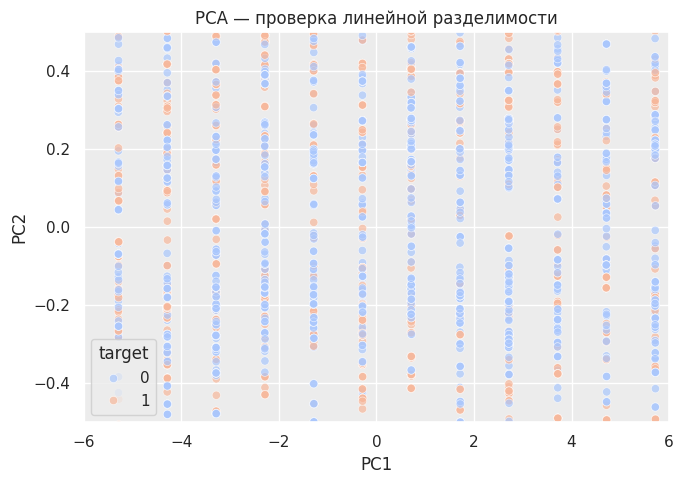

In [136]:
# 🧩 Шумность — PCA Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['target'] = y_train.values

plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target', alpha=0.7, palette='coolwarm')
plt.title("PCA — проверка линейной разделимости")
plt.xlim([-6, 6])
plt.ylim([-0.5, 0.5])
plt.tight_layout()
plt.show()